In [1]:
%matplotlib inline

from matplotlib import pyplot as pl
import daft
import pymc3 as pm
import numpy as np

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


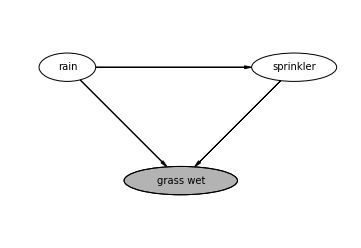

In [2]:
pgm = daft.PGM([6, 4], origin=[2, 1])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sprinkler', 7, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 5, 2, aspect=4, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

Using some observations about whether it has rained, whether the sprinkler has been on, and whether the grass is wet, fit the conditional probability table values for the Bayesian network [above](https://en.wikipedia.org/wiki/Bayesian_network#Example).

In [6]:
# set the observations
has_rained =   np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1])
sprinkler_on = np.array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
grass_wet =    np.array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    # conditional probability for s
    sprinkrain = pm.Uniform('sprinkrain', 0., 1.)
    sprinknorain = pm.Uniform('sprinknorain', 0., 1.)
    
    psprinkrain = pm.Bernoulli('psprinkrain', sprinkrain,
                               observed=(has_rained & sprinkler_on))
    psprinknorain = pm.Bernoulli('psprinknorain', sprinknorain,
                                 observed=(sprinkler_on & ~has_rained))

    wetsprinkrain = pm.Uniform('wetsprinkrain', 0., 1.)
    wetsprinknorain = pm.Uniform('wetsprinknorain', 0., 1.)
    wetnosprinkrain = pm.Uniform('wetnosprinkrain', 0., 1.)
    wetnosprinknorain = pm.Uniform('wetnosprinknorain', 0., 1.)
    
    pwetsprinkrain = pm.Bernoulli('pwetsprinkrain', wetsprinkrain,
                                  observed=(grass_wet & sprinkler_on & has_rained))
    pwetsprinknorain = pm.Bernoulli('pwetsprinknorain', wetsprinknorain,
                                    observed=(grass_wet & sprinkler_on & ~has_rained))
    pwetnosprinkrain = pm.Bernoulli('pwetnosprinkrain', wetnosprinkrain,
                                    observed=(grass_wet & has_rained & ~sprinkler_on))
    pwetnosprinknorain = pm.Bernoulli('pwetnosprinknorain', wetnosprinknorain,
                                      observed=(grass_wet & ~has_rained & ~sprinkler_on))
    
    trace = pm.sample(1000, tune=2000, discard_tuned_samples=True, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [wetnosprinknorain, wetnosprinkrain, wetsprinknorain, wetsprinkrain, sprinknorain, sprinkrain, prain]
100%|██████████| 3000/3000 [09:27<00:00,  5.15it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
np.array(has_rained) & np.array(sprinkler_on)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

(array([ 23., 110., 186., 133., 173., 136.,  55.,  77.,  85.,  22.]),
 array([0.28791386, 0.32313772, 0.35836158, 0.39358544, 0.4288093 ,
        0.46403317, 0.49925703, 0.53448089, 0.56970475, 0.60492861,
        0.64015247]),
 <a list of 10 Patch objects>)

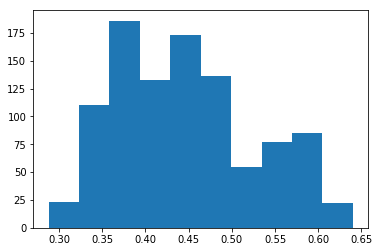

In [7]:
pl.hist(trace['prain'])

In [24]:
np.sum(has_rained)/len(has_rained)

0.5

Following the example [here](https://gist.github.com/cs224/9a19b4ba2c7511e317be90c32a4d40d7#file-pymc3_rain_sprinkler_grass_simple_bayesian_network_with_evidence-py) add in prediction variables.

In [9]:
# set the observations
has_rained =   np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1])
sprinkler_on = np.array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
grass_wet =    np.array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])

# new observation (grass is wet)
new_grass_wet = np.array([1])

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    psprinkler = pm.Uniform('psprinker', 0.0, 1.0)  # prior on probability of sprinkler on
    sprinkler = pm.Bernoulli('sprinkler', psprinkler, observed=sprinkler_on)
    
    pwet = pm.Uniform('pwet', 0.0, 1.0)  # prior on probability of grass being wet
    wet = pm.Bernoulli('wet', pwet, observed=grass_wet)
    
    # conditional probability for sprinkler
    sprinkrain = pm.Uniform('sprinkrain', 0., 1.)
    sprinknorain = pm.Uniform('sprinknorain', 0., 1.)
    
    psprinkrain = pm.Bernoulli('psprinkrain', sprinkrain,
                               observed=(has_rained & sprinkler_on))
    psprinknorain = pm.Bernoulli('psprinknorain', sprinknorain,
                                 observed=(sprinkler_on & ~has_rained))
    
    wetsprinkrain = pm.Uniform('wetsprinkrain', 0., 1.)
    wetsprinknorain = pm.Uniform('wetsprinknorain', 0., 1.)
    wetnosprinkrain = pm.Uniform('wetnosprinkrain', 0., 1.)
    wetnosprinknorain = pm.Uniform('wetnosprinknorain', 0., 1.)
    
    pwetsprinkrain = pm.Bernoulli('pwetsprinkrain', wetsprinkrain,
                                  observed=(grass_wet & sprinkler_on & has_rained))
    pwetsprinknorain = pm.Bernoulli('pwetsprinknorain', wetsprinknorain,
                                    observed=(grass_wet & sprinkler_on & ~has_rained))
    pwetnosprinkrain = pm.Bernoulli('pwetnosprinkrain', wetnosprinkrain,
                                    observed=(grass_wet & has_rained & ~sprinkler_on))
    pwetnosprinknorain = pm.Bernoulli('pwetnosprinknorain', wetnosprinknorain,
                                      observed=(grass_wet & ~has_rained & ~sprinkler_on))
    
    # probability of sprinkler being on
    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(rain, sprinkrain, sprinknorain))
    
    # probability of grass being wet
    grass_wet_p = pm.Deterministic('grass_wet_p', pm.math.switch(rain,
                                                                 pm.math.switch(sprinkler, wetsprinkrain, wetnosprinkrain),
                                                                 pm.math.switch(sprinkler, wetsprinknorain, wetnosprinknorain)))

    # grass wet new observation
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p, observed=new_grass_wet, shape=1)
    
    trace = pm.sample(1000, tune=2000, discard_tuned_samples=True, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [wetnosprinknorain, wetnosprinkrain, wetsprinknorain, wetsprinkrain, sprinknorain, sprinkrain, pwet, psprinker, prain]
100%|██████████| 3000/3000 [11:25<00:00,  4.26it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


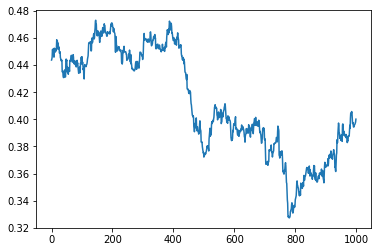

In [11]:
pl.plot(trace['prain'])

In [31]:
# set the observations
has_rained =   np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
                         1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
                         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1])

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)
    
    trace = pm.sample(2000, tune=4000, discard_tuned_samples=True, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prain]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:05<00:00, 2049.42draws/s]


(array([  29.,  118.,  397.,  841., 1046.,  866.,  483.,  166.,   43.,
          11.]),
 array([0.33608433, 0.35241132, 0.36873831, 0.3850653 , 0.40139229,
        0.41771929, 0.43404628, 0.45037327, 0.46670026, 0.48302725,
        0.49935424]),
 <a list of 10 Patch objects>)

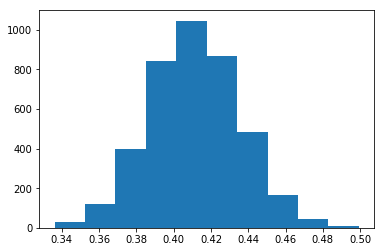

In [32]:
pl.hist(trace['prain'])

In [33]:
print(np.mean(has_rained))
print(np.mean(trace['prain']))

0.4117647058823529
0.4114399643940026


In [34]:
np.std(trace['prain'])

0.02433580370012599

(array([  11.,   43.,  166.,  483.,  866., 1046.,  841.,  397.,  118.,
          29.]),
 array([0.50064576, 0.51697275, 0.53329974, 0.54962673, 0.56595372,
        0.58228071, 0.59860771, 0.6149347 , 0.63126169, 0.64758868,
        0.66391567]),
 <a list of 10 Patch objects>)

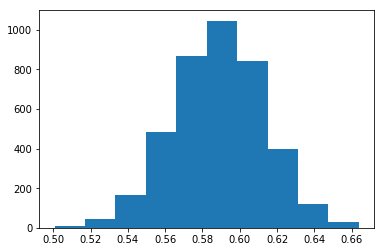

In [35]:
pl.hist(1.-trace['prain'])